In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss,CondensedNearestNeighbour
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [45]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [46]:
# ----------------------------- #
# 📌 3. DATA PREPROCESSING (Before Splitting)
# ----------------------------- #
df = df.drop(columns=['customerID'], errors='ignore')

# Convert 'TotalCharges' to numeric (if applicable)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Replace 'No internet service' and 'No phone service' with 'No'
df.replace(['No internet service', 'No phone service'], 'No', inplace=True)

# Fill missing values in numerical columns with the column mean
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)


# Convert categorical variables into numerical using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Drop 'customerID' if it exists
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)


In [47]:
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0,45,42.30,1840.75,True,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,True,False,True,...,False,False,False,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,True,True,True,True,True,False,...,True,True,True,True,False,True,False,False,True,False
7039,0,72,103.20,7362.90,False,True,True,True,True,True,...,False,True,True,True,False,True,True,False,False,False
7040,0,11,29.60,346.45,False,True,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
7041,1,4,74.40,306.60,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,True,True


### Separate 20% of the data for testing
For model evaluation on totally unseen data

In [48]:
X = df.drop(columns=['Churn_Yes'])  # Features
y = df['Churn_Yes']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Exploratory Data Analysis

**Distribution of target column:**

Churn_Yes
False    4139
True     1495
Name: count, dtype: int64


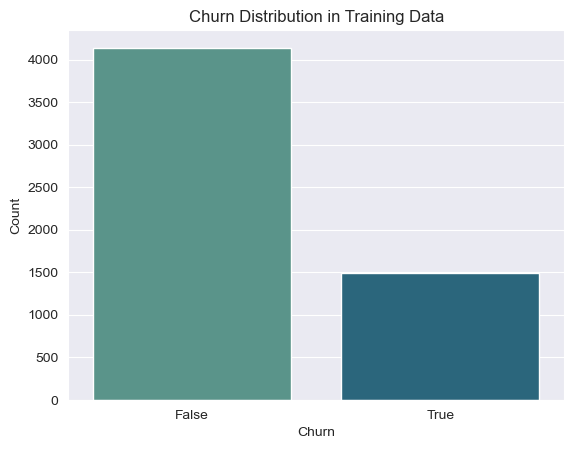

In [49]:
print(y_train.value_counts())

sns.countplot(x=y_train, palette='crest')
plt.title('Churn Distribution in Training Data')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


- The distribution of the binary classes shows a slight data imbalance that needs attention

**Categorical features count plot**

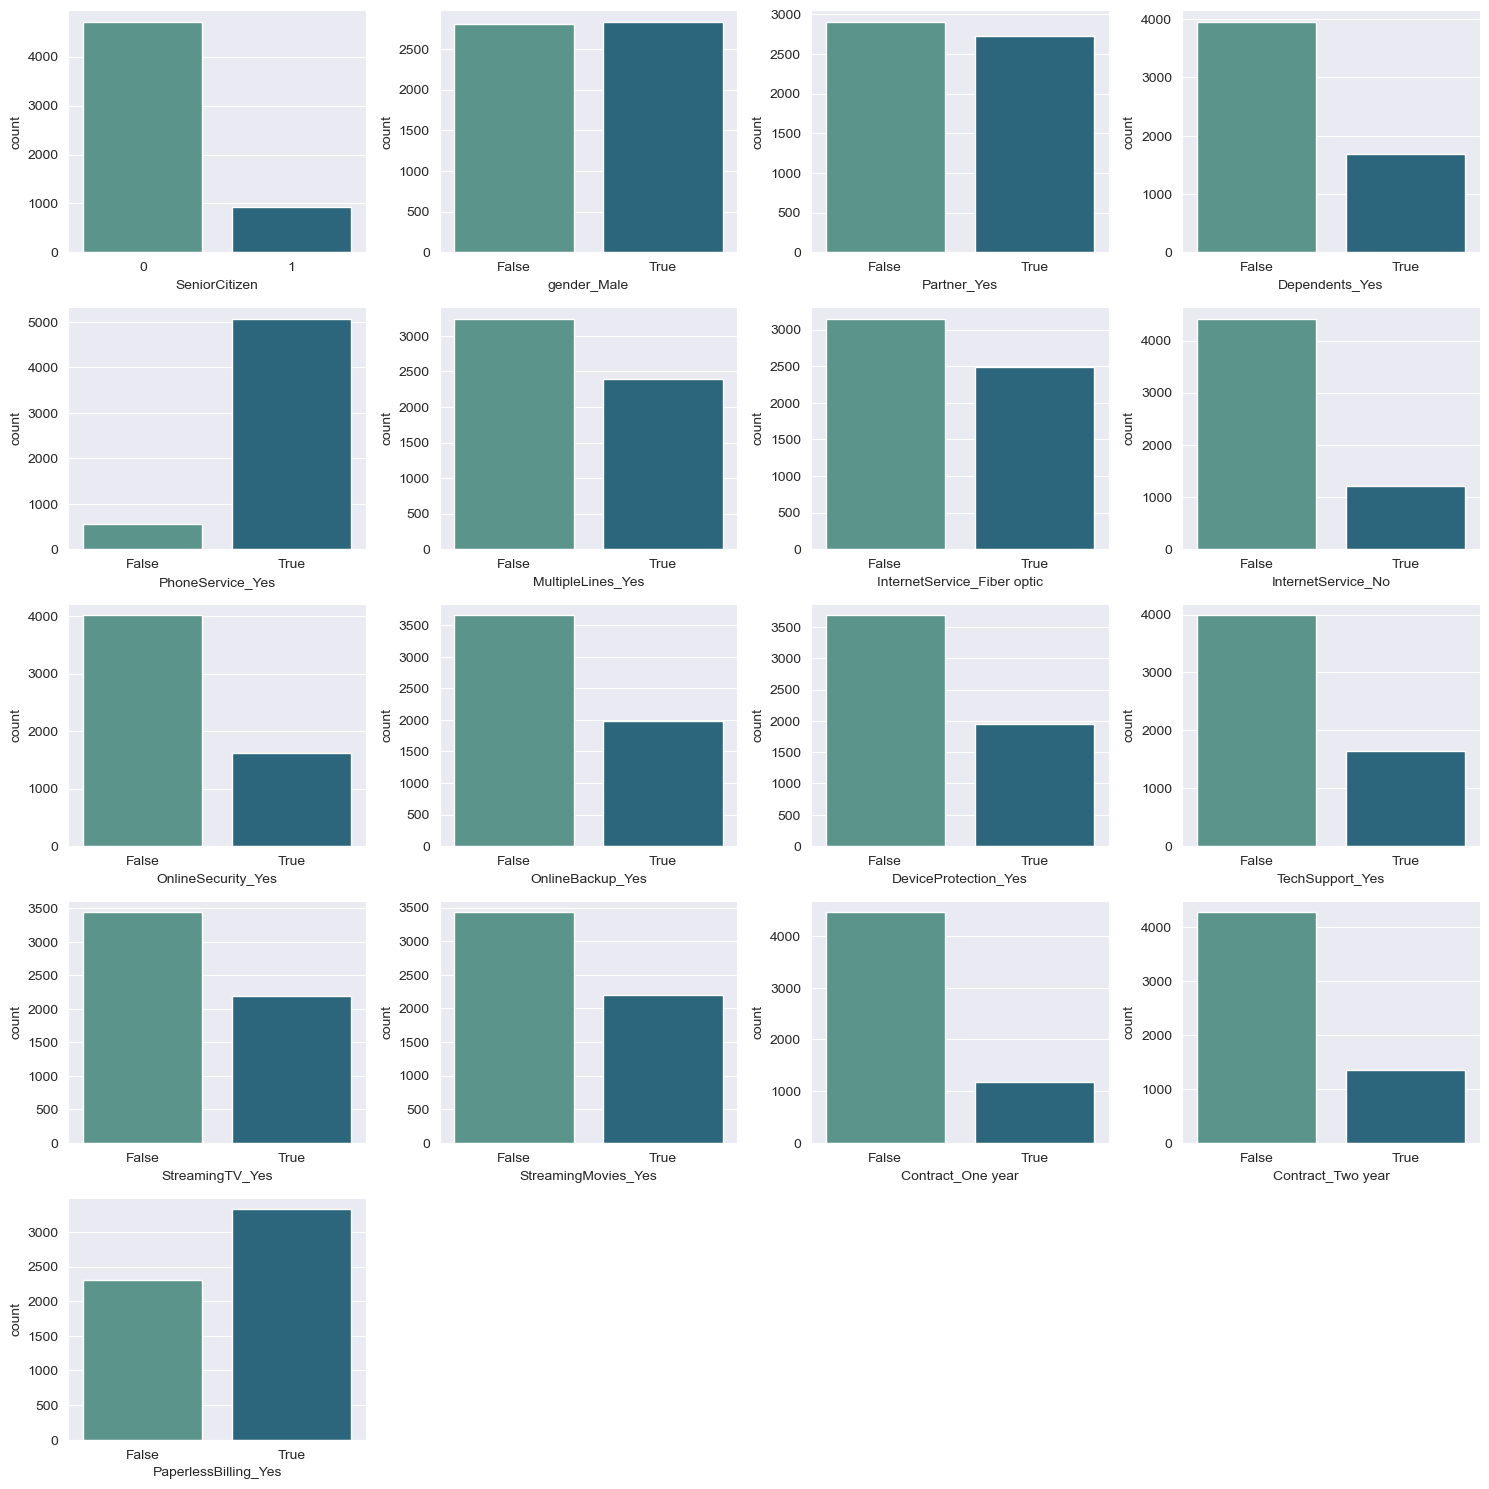

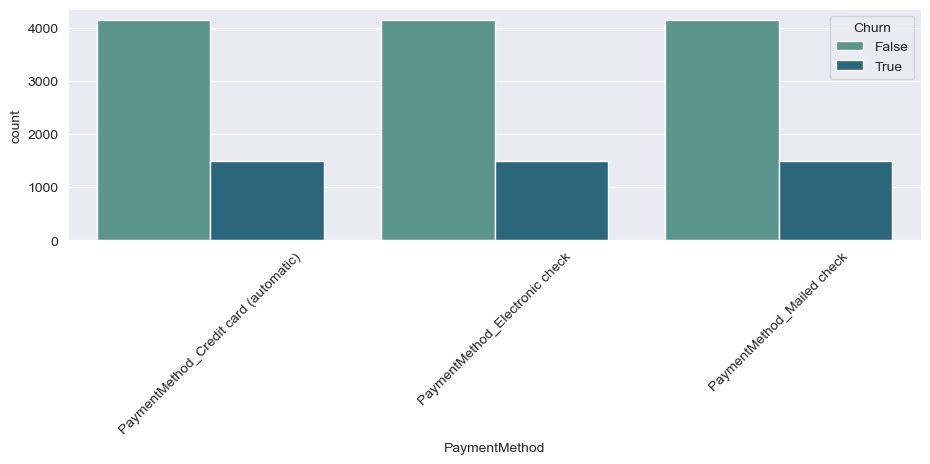

In [50]:

# Identify categorical features after encoding
cat_cols = [col for col in X_train.columns if any(feature in col for feature in
              ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
               'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaperlessBilling'])]

# Combine X_train and y_train into a single DataFrame for visualization
train_data = X_train.copy()
train_data['Churn'] = y_train

plt.figure(figsize=(15, 15))
for n, variable in enumerate(cat_cols):
    ax = plt.subplot(5, 4, n + 1)
    sns.countplot(data=train_data, x=variable, ax=ax, palette='crest')
plt.tight_layout()
plt.show()

# Check for PaymentMethod features after encoding
payment_cols = [col for col in X_train.columns if 'PaymentMethod' in col]

# Plot payment method distribution with churn
plt.figure(figsize=(11, 3))
train_data_long = train_data.melt(id_vars=['Churn'], value_vars=payment_cols, var_name='PaymentMethod', value_name='Value')
sns.countplot(x='PaymentMethod', hue='Churn', data=train_data_long, palette='crest')
plt.xticks(rotation=45)
plt.show()


- The gender count plot shows an equally distribution of males and females in the dataset
- Some features have 'No' and 'No Internet Service' or 'No Phone Service' as a separate category which don't give new info and could all be considered as 'No' label

**Histogram & Boxplots of continous features**

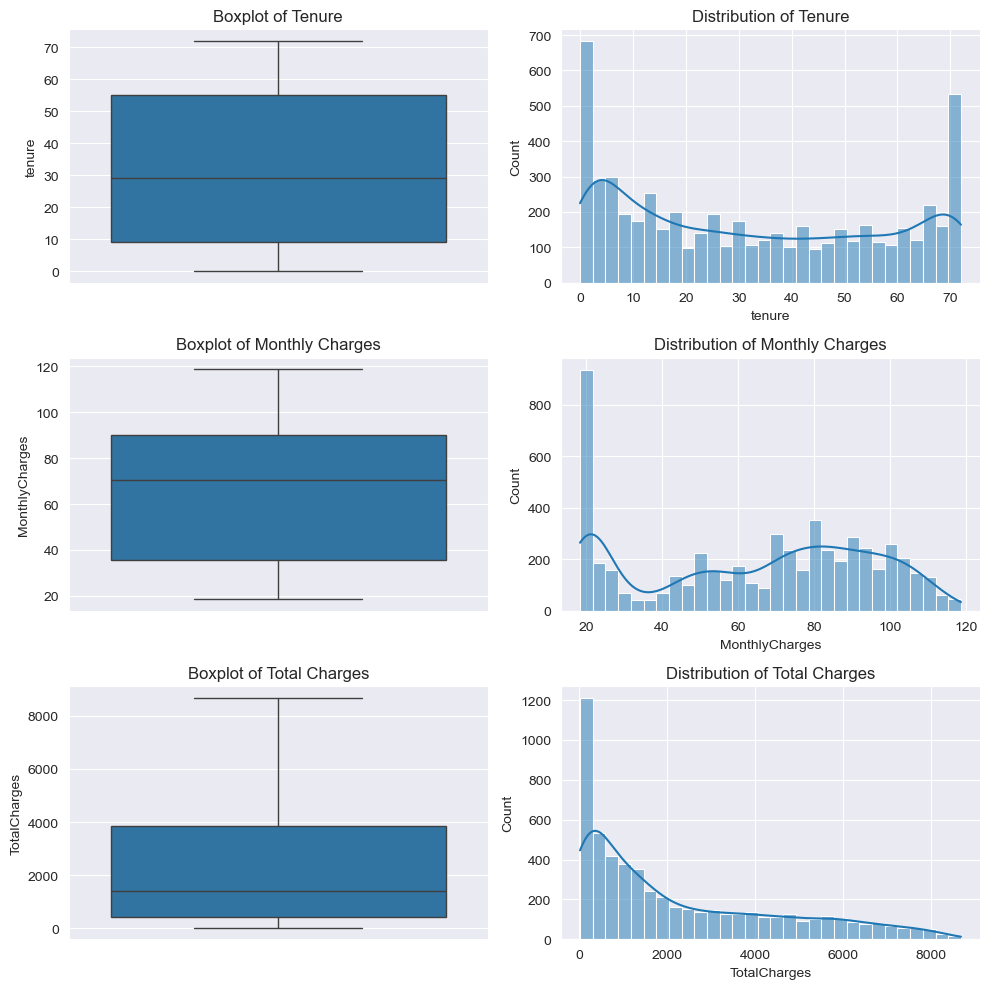

In [51]:
plt.figure(figsize=(10, 10))

# Tenure Boxplot
plt.subplot(3, 2, 1)
sns.boxplot(y=X_train['tenure'])
plt.title('Boxplot of Tenure')

# Tenure Histogram
plt.subplot(3, 2, 2)
sns.histplot(X_train['tenure'], kde=True, bins=30)
plt.title('Distribution of Tenure')

# Monthly Charges Boxplot
plt.subplot(3, 2, 3)
sns.boxplot(y=X_train['MonthlyCharges'])
plt.title('Boxplot of Monthly Charges')

# Monthly Charges Histogram
plt.subplot(3, 2, 4)
sns.histplot(X_train['MonthlyCharges'], kde=True, bins=30)
plt.title('Distribution of Monthly Charges')

# Total Charges Boxplot
plt.subplot(3, 2, 5)
sns.boxplot(y=X_train['TotalCharges'])
plt.title('Boxplot of Total Charges')

# Total Charges Histogram
plt.subplot(3, 2, 6)
sns.histplot(X_train['TotalCharges'], kde=True, bins=30)
plt.title('Distribution of Total Charges')

plt.tight_layout()
plt.show()


- Boxplots show that there are No outliers in the continuous variables
- Histograms show right skewness in the 'TotalCharges' feature

**Scatter plot of Monthly Charges versus Total Charges**

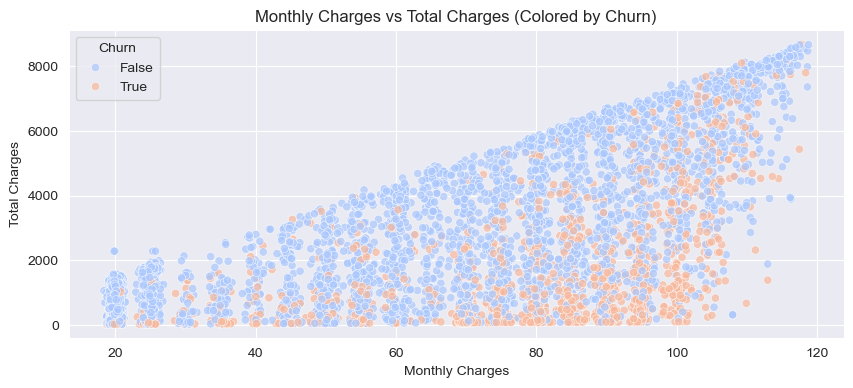

In [52]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x=X_train['MonthlyCharges'], y=X_train['TotalCharges'], hue=y_train, palette='coolwarm', alpha=0.7)
plt.title('Monthly Charges vs Total Charges (Colored by Churn)')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='Churn')
plt.show()


- This implies a positive correlation between the monthly charges, and total charges.
- The churn rate increases with the increase in monthly charges.

In [53]:
print(df.head())  # Check if 'InternetService', 'PhoneService' exist as numeric columns


   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
0              0       1           29.85         29.85        False   
1              0      34           56.95       1889.50         True   
2              0       2           53.85        108.15         True   
3              0      45           42.30       1840.75         True   
4              0       2           70.70        151.65        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_Yes  \
0         True           False             False              False   
1        False           False              True              False   
2        False           False              True              False   
3        False           False             False              False   
4        False           False              True              False   

   InternetService_Fiber optic  ...  TechSupport_Yes  StreamingTV_Yes  \
0                        False  ...            False            False   


# handling data imbalance

In [54]:
sm = SMOTE(random_state=0, sampling_strategy='minority', k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train, y_train.to_numpy())

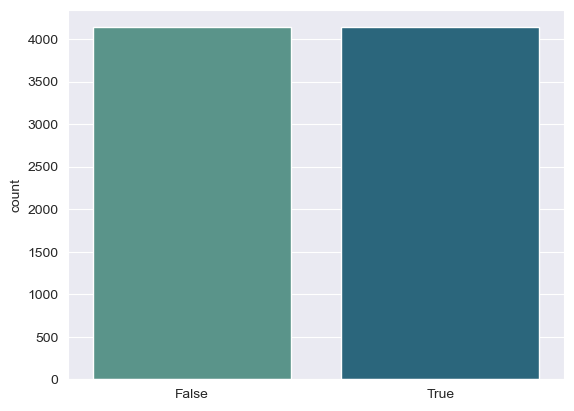

In [55]:
_ = sns.countplot(x=y_train, palette='crest')

In [56]:
X_train

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,35,49.200000,1701.650000,True,False,False,False,False,False,...,True,False,True,True,False,False,False,False,True,False
1,0,15,75.100000,1151.550000,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,True
2,0,13,40.550000,590.350000,True,True,True,False,False,False,...,False,True,False,False,False,True,False,False,False,True
3,0,26,73.500000,1905.700000,False,True,False,True,False,False,...,True,False,True,True,False,True,True,True,False,False
4,0,1,44.550000,44.550000,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8273,0,23,95.792286,2305.491549,True,False,False,True,True,True,...,False,False,True,True,False,False,True,False,True,False
8274,0,55,103.196425,5757.291023,True,True,False,True,True,True,...,True,False,True,True,True,False,True,False,True,False
8275,0,65,104.089112,6889.815777,True,True,False,True,True,True,...,True,True,True,True,True,False,True,False,True,False
8276,0,62,99.323379,6403.359999,False,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,False


# Standardize Features

In [57]:
# Store feature names before scaling
feature_columns = X.columns.tolist()  # Save column names BEFORE scaling



In [58]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model training
Trainig different models on the data to compare results of each model

1. **Logistic Regression**

In [59]:
model_logReg = LogisticRegression(C=200, max_iter=1000)

scores = cross_val_score(model_logReg, X_train, y_train, cv=10, scoring="f1")
print(scores)
model_logReg.fit(X_train, y_train)

[0.71369295 0.67787115 0.66951567 0.77935484 0.887078   0.88228571
 0.9059633  0.87827076 0.87197232 0.87991021]


LogisticRegression(C=200, max_iter=1000)

- **Confusion matrix**

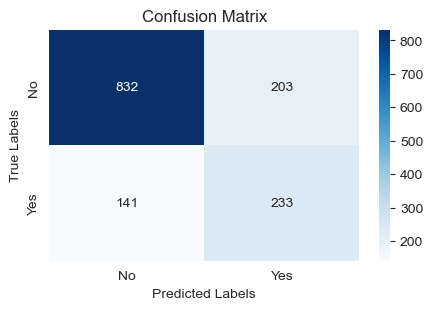

Accuracy: 0.7558552164655784
Precision: 0.5344036697247706
Recall: 0.6229946524064172
F1 Score: 0.5753086419753086


In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model_logReg.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.show()

# Print additional evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


- **Classification report**

In [61]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


              precision    recall  f1-score   support

          No       0.86      0.80      0.83      1035
         Yes       0.53      0.62      0.58       374

    accuracy                           0.76      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.76      0.76      1409



## 2- Random Forest

**Testing the model**

In [62]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.7735982966643009
Precision: 0.5721784776902887
Recall: 0.5828877005347594
F1 Score: 0.5774834437086093


- **Confusion matrix**

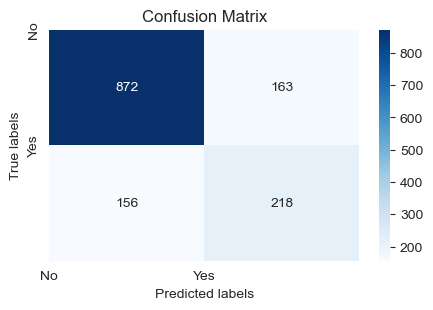

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the Random Forest model
rf_pred = model_rf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_pred)

# Plot the heatmap
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.yticks(ticks=[0,1], labels=['No', 'Yes'])

plt.show()


- **Classification report**

In [64]:
from sklearn.metrics import classification_report

# Get predictions from the Random Forest model
rf_pred = model_rf.predict(X_test)

# Print the classification report
print(classification_report(y_test, rf_pred, target_names=['No', 'Yes']))


              precision    recall  f1-score   support

          No       0.85      0.84      0.85      1035
         Yes       0.57      0.58      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



In [65]:
!pip install lightgbm


## 3- LightGBM

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

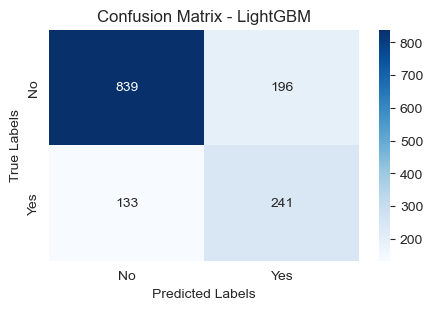

              precision    recall  f1-score   support

          No       0.86      0.81      0.84      1035
         Yes       0.55      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409

Accuracy: 0.7665010645848119
Precision: 0.551487414187643
Recall: 0.6443850267379679
F1 Score: 0.594327990135635


In [66]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define LightGBM model
model_lgb = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.08, max_depth=5, random_state=42)

# Train model
model_lgb.fit(X_train, y_train)

# Predictions
lgb_pred = model_lgb.predict(X_test)

# Confusion Matrix
cm_lgb = confusion_matrix(y_test, lgb_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5,3))
sns.heatmap(cm_lgb, annot=True, fmt='g', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LightGBM')
plt.xticks(ticks=[0.5,1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5,1.5], labels=['No', 'Yes'])
plt.show()

# Classification Report
print(classification_report(y_test, lgb_pred, target_names=['No', 'Yes']))
print("Accuracy:", accuracy_score(y_test, lgb_pred))
print("Precision:", precision_score(y_test, lgb_pred))
print("Recall:", recall_score(y_test, lgb_pred))
print("F1 Score:", f1_score(y_test, lgb_pred))


**Testing the model**

## 4- Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the Decision Tree model
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)
model_dt.fit(X_train, y_train)

# Make predictions
dt_pred = model_dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, dt_pred))
print("Precision:", precision_score(y_test, dt_pred))
print("Recall:", recall_score(y_test, dt_pred))
print("F1 Score:", f1_score(y_test, dt_pred))


Accuracy: 0.730305180979418
Precision: 0.4945652173913043
Recall: 0.7299465240641712
F1 Score: 0.5896328293736501


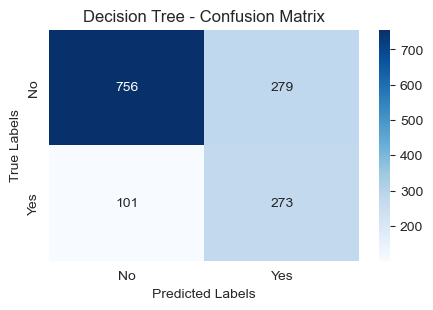

In [68]:
# Compute confusion matrix
cm = confusion_matrix(y_test, dt_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Decision Tree - Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.show()


- **Classification report**

In [69]:
print(classification_report(y_test, dt_pred, target_names=['No', 'Yes']))


              precision    recall  f1-score   support

          No       0.88      0.73      0.80      1035
         Yes       0.49      0.73      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.73      0.69      1409
weighted avg       0.78      0.73      0.74      1409



In [70]:
print("User Input Features:", user_df.columns.tolist())  
print("Expected Features:", feature_columns)  
print("Missing Features:", missing_cols)


NameError: name 'user_df' is not defined

In [71]:
# Define expected features
expected_features = [
    'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male', 
    'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 
    'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 
    'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 
    'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 
    'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'
]

# Ensure all expected features exist in df
for feature in expected_features:
    if feature not in df.columns:
        df[feature] = 0  # Fill missing columns with default value

# Reorder columns to match expected structure
df = df[expected_features]


In [72]:
missing_features = {'SeniorCitizen', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check', 
                    'MultipleLines_Yes', 'DeviceProtection_Yes', 'PaperlessBilling_Yes', 'TechSupport_Yes', 
                    'OnlineBackup_Yes', 'StreamingMovies_Yes', 'Dependents_Yes', 'InternetService_No', 
                    'PhoneService_Yes', 'StreamingTV_Yes', 'Partner_Yes', 'OnlineSecurity_Yes'}

for feature in missing_features:
    if feature not in df.columns:
        df[feature] = 0  # Fill missing columns with default value

df = df[expected_features]  # Ensure correct column order


In [73]:
import numpy as np
import pandas as pd

def predict_churn(user_input, model, scaler, feature_columns):
    """
    Predicts customer churn based on user input.

    Parameters:
    - user_input: Dictionary with customer features.
    - model: Trained model (RandomForest, LogisticRegression, etc.).
    - scaler: Pre-fitted scaler for numerical feature transformation.
    - feature_columns: List of expected feature columns after encoding.

    Returns:
    - "Churn" or "No Churn"
    """
    # Convert user input into a DataFrame
    user_df = pd.DataFrame([user_input])

    # One-hot encode categorical variables
    user_df = pd.get_dummies(user_df)

    # Align features with training data (handle missing columns)
    missing_cols = set(feature_columns) - set(user_df.columns)
    for col in missing_cols:
        user_df[col] = 0  

    # Ensure column order matches training data
    user_df = user_df[feature_columns]

    # Scale user input using the same scaler used for training data
    user_scaled = scaler.transform(user_df)  # Scale user input

    # Predict churn
    prediction = model.predict(user_scaled)

    return "Churn" if prediction[0] == 1 else "No Churn"


In [74]:
import pickle

# Save the best model
with open("model.pkl", "wb") as file:
    pickle.dump(model_rf, file)  # Change this to your best model (e.g., model_logReg, model_lgb)
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

In [75]:
import pickle

# Load the trained model
with open("model.pkl", "rb") as file:
    model = pickle.load(file)


In [76]:
sample_input = {
    'SeniorCitizen': 1,
    'tenure': 1,
    'MonthlyCharges': 100,
    'TotalCharges': 100,
    'gender_Male': 1,
    'Partner_Yes': 0,
    'Dependents_Yes': 0,
    'PhoneService_Yes': 1,
    'MultipleLines_Yes': 1,
    'InternetService_Fiber optic': 1,
    'InternetService_No': 0,
    'OnlineSecurity_Yes': 0,
    'OnlineBackup_Yes': 0,
    'DeviceProtection_Yes': 0,
    'TechSupport_Yes': 0,
    'StreamingTV_Yes': 1,
    'StreamingMovies_Yes': 1,
    'Contract_One year': 0,
    'Contract_Two year': 0,
    'PaperlessBilling_Yes': 1,
    'PaymentMethod_Credit card (automatic)': 0,
    'PaymentMethod_Electronic check': 1,
    'PaymentMethod_Mailed check': 0
}

# Convert the input into a DataFrame
input_df = pd.DataFrame([sample_input])

# Ensure input columns match the training feature set
missing_cols = set(feature_columns) - set(input_df.columns)
for col in missing_cols:
    input_df[col] = 0  # Add missing features with default values

# Reorder columns to match training data
input_df = input_df[feature_columns]

# Scale the input using the same scaler used for training data
input_scaled = scaler.transform(input_df)

# Make a prediction
prediction = model.predict(input_scaled)

# Print the result
print("Predicted Churn:", "Yes" if prediction[0] == 1 else "No")


Predicted Churn: Yes


In [78]:
import json

# Load the current notebook
with open("Customer_Churn_Prediction_(3)_google.ipynb", "r") as f:
    notebook_data = json.load(f)

# Extract and print all code cells
for cell in notebook_data["cells"]:
    if cell["cell_type"] == "code":
        print("\n".join(cell["source"]))
        print("\n" + "="*80 + "\n")  # Separator between cells


import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.ticker as mtick

import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn import metrics

from imblearn.over_sampling import SMOTE

from imblearn.under_sampling import NearMiss,CondensedNearestNeighbour

from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

from xgboost import XGBRegressor

from sklearn.neural_network import MLPClassifier

import warnings

warnings.filterwarnings('ignore')

sns.set_style("darkgrid")


df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df


# -------